# Project 2

Due date: July 27, 2021, 11:59 pm

- The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository.
- The project must be carried out in the groups assigned in class.
- Use clear and rigorous procedures.
- Due date: July 27, 2021, 11:59 pm, through Bloque Neón + (Upload repository link)
- Projects will not be received after the delivery time or by any other means than the one established.

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [124]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import arange
import multiprocessing
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor

import pickle

In [2]:
data = pd.read_csv('dataTrain_carListings.zip')

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [4]:
data.shape

(500000, 6)

In [5]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

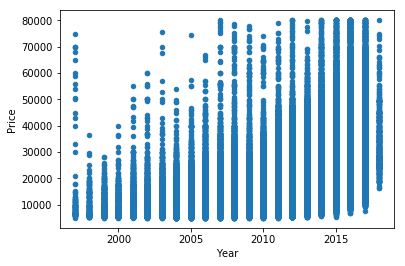

In [6]:
data.plot(kind='scatter', y='Price', x='Year')

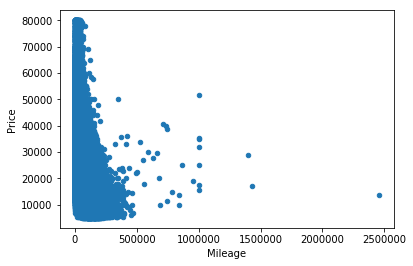

In [7]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [8]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation.
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models. Present the most relevant conslusions about the whole process. 


## Solución

### Descripción de los datos

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    500000 non-null  int64 
 1   Year     500000 non-null  int64 
 2   Mileage  500000 non-null  int64 
 3   State    500000 non-null  object
 4   Make     500000 non-null  object
 5   Model    500000 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


In [10]:
data.groupby('State')['Price'].count()

State
 AK     1031
 AL     7873
 AR     3956
 AZ    13395
 CA    45643
 CO    13669
 CT     6178
 DC       10
 DE     1520
 FL    42244
 GA    22790
 HI     1486
 IA     2910
 ID     2153
 IL    21058
 IN     9833
 KS     4621
 KY     8331
 LA     4788
 MA    10753
 MD    10327
 ME     1197
 MI     6677
 MN     6782
 MO     9966
 MS     3843
 MT     1229
 NC    22363
 ND      855
 NE     3150
 NH     3413
 NJ    15220
 NM     2890
 NV     4134
 NY    15617
 OH    14171
 OK     6374
 OR     6128
 PA    16337
 RI     1065
 SC     6026
 SD      764
 TN    11569
 TX    57153
 UT     6095
 VA    19851
 VT      715
 WA    13637
 WI     6950
 WV      833
 WY      427
Name: Price, dtype: int64

In [11]:
data.groupby('Make')['Price'].mean()

Make
Acura            21403.549498
Audi             19640.258929
BMW              25272.708661
Bentley          57455.095890
Buick            21220.334312
Cadillac         25568.179727
Chevrolet        23373.090960
Chrysler         16707.204262
Dodge            18074.691991
FIAT              9060.147929
Ford             22550.601028
Freightliner     26209.142857
GMC              28546.075338
Honda            17025.912871
Hyundai          14758.422306
INFINITI         16492.736426
Jaguar           19547.286730
Jeep             23378.251965
Kia              15913.867007
Land             36232.099500
Lexus            25861.963158
Lincoln          22906.473247
MINI             15213.863311
Mazda            14098.436653
Mercedes-Benz    30087.658629
Mercury           7767.018462
Mitsubishi       13494.956254
Nissan           16254.156744
Pontiac           7160.559194
Porsche          34534.385000
Ram              31420.468584
Scion             9556.065000
Subaru           19163.805154
Suzuk

In [12]:
data.groupby('Model')['Price'].mean()

Model
1                15609.709559
15002WD          18135.846702
15004WD          22476.222760
1500Laramie      34954.725234
1500Tradesman    28654.177305
                     ...     
Yukon4WD         42035.878866
Yukon4dr          8743.032258
tC2dr            10247.631737
xB5dr             9267.763380
xD5dr             8397.180180
Name: Price, Length: 525, dtype: float64

Se observa que las variables Model, State y Make son variables categóricas con muchos niveles, en este caso se procederá a usar one hot encoding, para trabajarlas como dummys. 

In [28]:
x1 = pd.get_dummies(data[['Mileage','State','Model','Make','Price']])
x1.shape

(500000, 616)

Al realizar este procedimiento, se obtienen un total de 616 variables, a continuación se seleccionarán las categorías que representan el 80% con mayor frecuencia.

### Selección de variables

**State**

In [29]:
df = data['State'].value_counts().to_frame()
df["acum_1"] = df["State"].cumsum()/df["State"].sum()*100

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


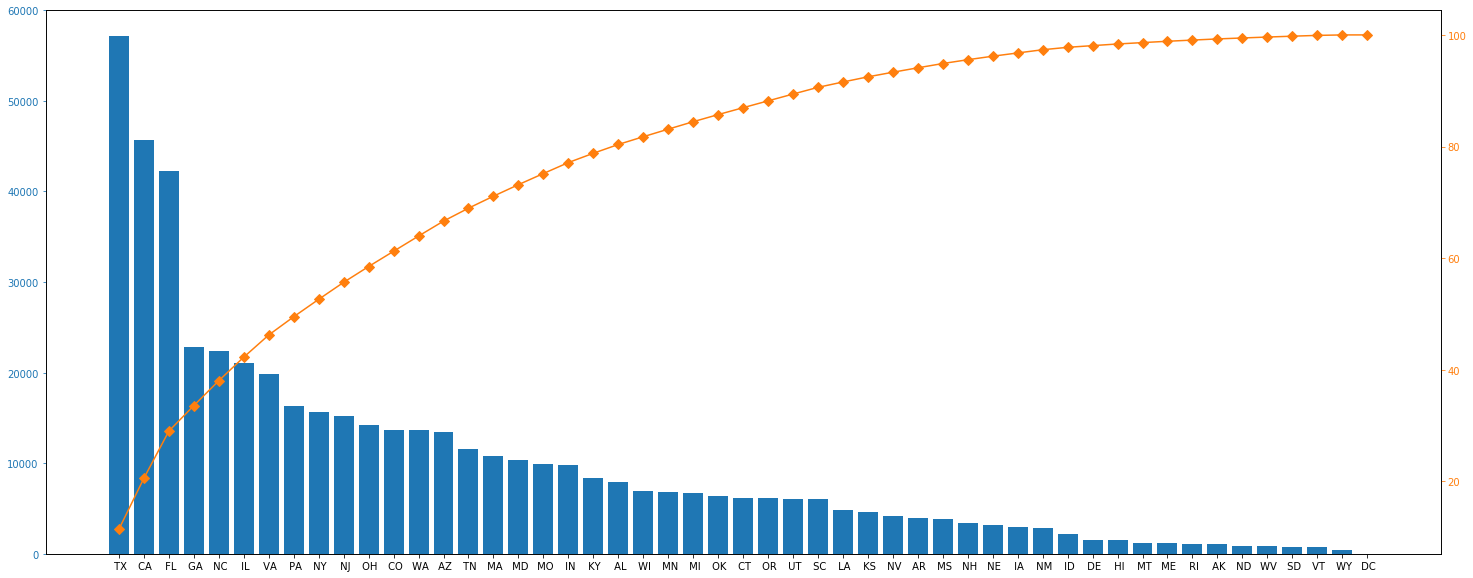

In [30]:
plt.rcParams["figure.figsize"] = (25,10)

fig, ax = plt.subplots()
ax.bar(df.index, df["State"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["acum_1"], color="C1", marker="D", ms=7)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [31]:
state_list=list(df[df['acum_1']<=80].index)
data['State_new']=np.where(data['State'].isin(state_list),data['State'],"OTRO")

In [37]:
print("Categorias iniciales:", data['State'].nunique(),",","Categorias finales:", len(state_list))

Categorias iniciales: 51 , Categorias finales: 20


La variable original state tenía 51 categorías, luego de escoger el 80% más frecuente, nos quedamos con 19 categorias y al restante lo marcamos como "otro", obteniendo un total de 20 categorías.

**Model**

In [38]:
df1 = data['Model'].value_counts().to_frame()
df1["acum_2"] = df1["Model"].cumsum()/df1["Model"].sum()*100

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


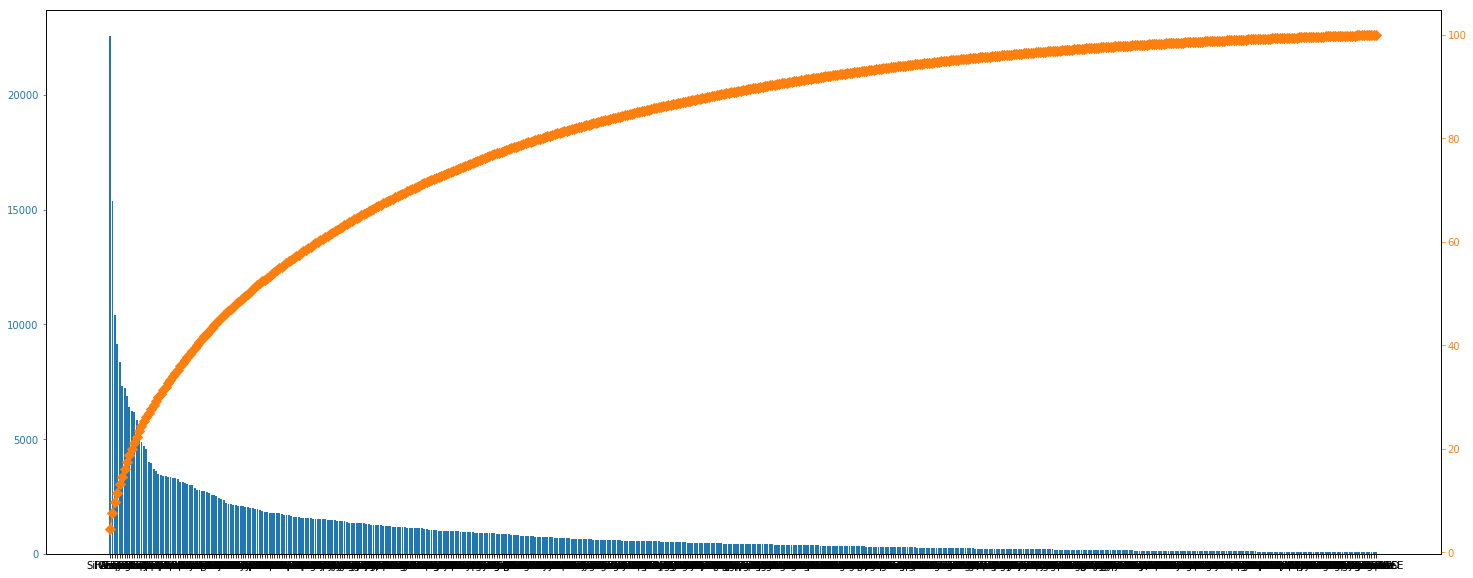

In [39]:
plt.rcParams["figure.figsize"] = (25,10)

fig, ax = plt.subplots()
ax.bar(df1.index, df1["Model"], color="C0")
ax2 = ax.twinx()
ax2.plot(df1.index, df1["acum_2"], color="C1", marker="D", ms=7)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [40]:
Model_list=list(df1[df1['acum_2']<=80].index)
data['Model_new']=np.where(data['Model'].isin(Model_list),data['Model'],"OTRO")

In [41]:
data['Model_new'].value_counts()

OTRO             100155
Silverado         22562
Grand             15382
Sierra            10423
Accord             9145
                  ...  
Pathfinder4WD       768
X5AWD               757
PriusThree          748
Camry               742
RAV44WD             738
Name: Model_new, Length: 180, dtype: int64

In [43]:
print("Categorias iniciales:", data['Model'].nunique(),",","Categorias finales:", len(Model_list))

Categorias iniciales: 525 , Categorias finales: 179


La variable original Model tenía 525 categorías, luego de escoger el 80% más frecuente, nos quedamos con 178 categorias y al restante lo marcamos como "otro", obteniendo un total de 179 categorías.

**Make**

In [44]:
df2 = data['Make'].value_counts().to_frame()
df2["acum_3"] = df2["Make"].cumsum()/df2["Make"].sum()*100

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


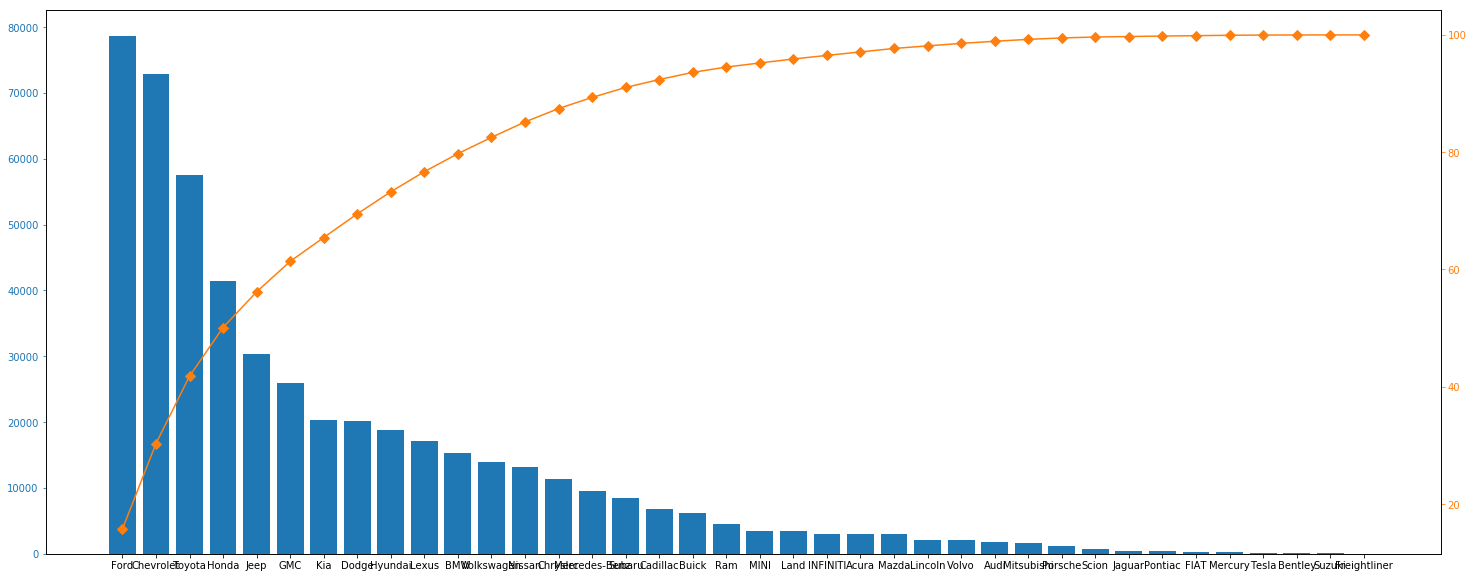

In [45]:
plt.rcParams["figure.figsize"] = (25,10)

fig, ax = plt.subplots()
ax.bar(df2.index, df2["Make"], color="C0")
ax2 = ax.twinx()
ax2.plot(df2.index, df2["acum_3"], color="C1", marker="D", ms=7)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [46]:
Make_list=list(df2[df2['acum_3']<=80].index)
data['Make_new']=np.where(data['Make'].isin(Make_list),data['Make'],"OTRO")

In [47]:
data['Make_new'].value_counts()

OTRO         101247
Ford          78627
Chevrolet     72900
Toyota        57485
Honda         41490
Jeep          30413
GMC           25963
Kia           20347
Dodge         20178
Hyundai       18856
Lexus         17127
BMW           15367
Name: Make_new, dtype: int64

In [48]:
print("Categorias iniciales:", data['Make'].nunique(),",","Categorias finales:", len(Make_list))

Categorias iniciales: 38 , Categorias finales: 11


La variable original Make tenía 38 categorías, luego de escoger el 80% más frecuente, nos quedamos con 10 categorias y al restante lo marcamos como "otro", obteniendo un total de 11 categorías.

In [50]:
data = data[['Year','Mileage','State_new','Model_new','Make_new','Price']]
x1 = data[['Year','Mileage','State_new','Model_new','Make_new']]
y1 = data['Price']
x1 = pd.get_dummies(x1)
x1.shape

(500000, 215)

Finalmente, seleccionamos **215 variables** que entrarán como predictoras para el modelamiento.

### Rendimiento modelamiento con CV

A continuación, se crea la función manual **cross_validate** para realizar validación cruzada en cualquier modelo con k particiones. En este caso, se usarán para todos 10 k-fold.

In [51]:
## Partición entre test y train

x_train, x_test, y_train, y_test = train_test_split(
                                     x1, y1, test_size=0.30, random_state=123)

data_final = x_train.copy()
data_final['Price'] = y_train

In [97]:
def cross_validate(CV, model, data):

    # Definición: cross_validate
    # Esta definición realizará validación cruzada, al modelo de interés dividiendolo en k-folds aleatoriamente.
    # Ejemplo: cross_validate(CV=10, model=DecisionTreeRegressor(random_state=1), data=data_final)
    # Salida: lista de los rmse de todos los k-fold
    
    rmse_total = []

    # División en k-fols aletoriamente
    
    shuffled = data.sample(frac=1, random_state=1)
    result = np.array_split(shuffled, CV)

    for i in range(0,CV):  

        result1 = result.copy()

        # Escoger la partición como test
        
        particion = result1[i].copy()
        
        x_test = particion.drop(columns='Price')
        y_test = particion['Price']

        result1.pop(i)
        
        # Escoger el complemento como train

        x_train = pd.concat(result1).drop(columns='Price')
        y_train = pd.concat(result1)['Price']
       
        # Ajuste del modelo de interés 

        model.fit(x_train, y_train)
        
        # Predicción del modelo ajustado 

        predicciones = model.predict(x_test)

        # RMSE de la partición
        
        rmse = mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predicciones
                   )
        print(f"El error (rmse) de test es: {np.sqrt(rmse)}")

        rmse_total.append(np.sqrt(rmse))

    return(rmse_total)

Se utilizará la función realizada para observar el desempeño de los diferentes modelos propuestos para la predicción del precio en los carros usados. Se realizará la validación cruzada con 10 k-fold.

**Árbol de decisión**

In [55]:
cross_arbol = cross_validate(CV=10, model=DecisionTreeRegressor(random_state=1), data=data_final)

El error (rmse) de test es: 6769.75969560676
El error (rmse) de test es: 6774.422421669401
El error (rmse) de test es: 6721.218060681625
El error (rmse) de test es: 6672.708002442219
El error (rmse) de test es: 6811.664820078569
El error (rmse) de test es: 6714.259436281273
El error (rmse) de test es: 6829.171683307831
El error (rmse) de test es: 6760.118406333011
El error (rmse) de test es: 6670.808985550793
El error (rmse) de test es: 6767.500797110302


In [62]:
rmse_arbol = np.mean(cross_arbol)
rmse_arbol

6749.163230906178

**Regresión Lineal - Ridge**

In [66]:
cross_ridge = cross_validate(CV=10, model=Ridge(random_state=1), data=data_final)

El error (rmse) de test es: 5801.018344568858
El error (rmse) de test es: 5667.917099541894
El error (rmse) de test es: 5703.082693278318
El error (rmse) de test es: 5607.729835186356
El error (rmse) de test es: 5805.955477642559
El error (rmse) de test es: 5637.879807279024
El error (rmse) de test es: 5700.499305331515
El error (rmse) de test es: 5762.600832354135
El error (rmse) de test es: 5576.546674831382
El error (rmse) de test es: 5681.544883287262


In [68]:
rmse_ridge = np.mean(cross_ridge)
rmse_ridge

5694.47749533013

**Random Forest**

In [71]:
cross_rf = cross_validate(CV=10, model=RandomForestRegressor(random_state=1, n_estimators=10), data=data_final)

El error (rmse) de test es: 5462.475854274673
El error (rmse) de test es: 5466.9216137233425
El error (rmse) de test es: 5401.430207582744
El error (rmse) de test es: 5353.851202279382
El error (rmse) de test es: 5529.544310372795
El error (rmse) de test es: 5383.332717079338
El error (rmse) de test es: 5452.052351221296
El error (rmse) de test es: 5464.9349383797835
El error (rmse) de test es: 5299.710920170726
El error (rmse) de test es: 5496.284288773138


In [72]:
rmse_rf = np.mean(cross_rf)
rmse_rf

5431.053840385722

**Gradient Boosting**

In [77]:
cross_gboost = cross_validate(CV=10, model=GradientBoostingRegressor(random_state=1), data=data_final)

El error (rmse) de test es: 6917.472212775387
El error (rmse) de test es: 6860.511187461544
El error (rmse) de test es: 6836.329315303919
El error (rmse) de test es: 6809.857413021914
El error (rmse) de test es: 6952.377483919632
El error (rmse) de test es: 6797.547862149714
El error (rmse) de test es: 6884.516502415409
El error (rmse) de test es: 6904.075189004035
El error (rmse) de test es: 6778.6924644352775
El error (rmse) de test es: 6907.657926363718


In [91]:
rmse_gboost = np.mean(cross_gboost)
rmse_gboost

6864.903755685055

**XGBoost**

In [89]:
cross_xgboost = cross_validate(CV=10, model=XGBRegressor(random_state=1), data=data_final)

El error (rmse) de test es: 6909.481816071308
El error (rmse) de test es: 6884.227843762992
El error (rmse) de test es: 6833.798699177473
El error (rmse) de test es: 6821.339037230268
El error (rmse) de test es: 6945.233424831813
El error (rmse) de test es: 6808.664575626614
El error (rmse) de test es: 6885.092475000693
El error (rmse) de test es: 6919.063321145872
El error (rmse) de test es: 6764.342389906615
El error (rmse) de test es: 6918.050151157018


In [90]:
rmse_xgboost = np.mean(cross_xgboost)
rmse_xgboost

6868.929373391065

**Resumen**

Para el ajuste de los 5 modelos propuestos luego de realizar la validación cruzada, el RMSE promedio de las particiones con los parámetros por defecto son:

In [95]:
print("Random Forest:", round(rmse_rf,2))
print("Regresión lineal ridge:", round(rmse_ridge,2))
print("Árbol de decisión:", round(rmse_arbol,2))
print("Grandient Boosting:", round(rmse_gboost,2))
print("XGBoost:", round(rmse_xgboost,2))

Random Forest: 5431.05
Regresión lineal ridge: 5694.48
Árbol de decisión: 6749.16
Grandient Boosting: 6864.9
XGBoost: 6868.93


De acuerdo a los resultados, se observa que el mejor rendimiento es el que se obtiene con el modelo ajustado con Random Forest. Por otro lado, el modelo con peor desempeño es el XGBoost. Estos modelos fueron ajustados con sus parámetros por defecto.

### Calibración de parámetros

**Árbol de decisión**

Para el árbol de decisión se calibrará el parámetro de profundidad, variandolo de 1 a 80 con salto de 15. Adicionalmente, se realizará validación cruzada para cada iteración con la función creada anteriormente.

In [100]:
max_depth_range = range(1, 80, 15)

rmse_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    cross_val = np.mean(cross_validate(CV=10, model=clf, data=data_final))
    rmse_scores.append(cross_val)
    print(cross_val)

9626.53612352283
7027.229272339437
6339.685751898238
6559.778624200681
6658.975322920951
6700.3095145038915


In [102]:
results_tree = pd.DataFrame({'alpha':max_depth_range,'rmse':rmse_scores})
depth_optimo = results_tree.sort_values(by=('rmse')).iloc[0,0]
depth_optimo

31

Text(0, 0.5, 'RMSE')

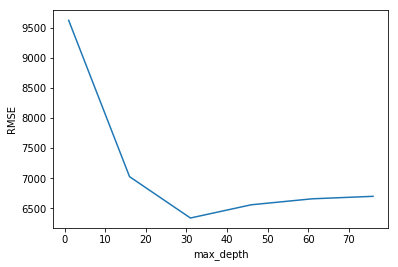

In [103]:
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

La profundidad óptima para el árbol de decisión es de 31.

In [104]:
clf = DecisionTreeRegressor(max_depth=depth_optimo, random_state=1)
clf.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=31, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [142]:
predict_arbol_train = clf.predict(X = x_train)
predict_arbol_test  = clf.predict(X = x_test)

In [143]:
rmse_arbol2 = mean_squared_error(
                y_true  = y_test,
                y_pred  = predict_arbol_test
               )
print(f"El error (rmse) de test es: {np.sqrt(rmse_arbol2)}")

El error (rmse) de test es: 6333.987203660371


**Regresión lineal - Ridge**

Para la regresión lineal con penalización Ridge se encontrará el alpha óptimo, variando el parámetro de 0 a 1 con salto de 0.1. Adicionalmente, se realizará validación cruzada para cada iteración con la función creada anteriormente.

In [117]:
alpharange = np.arange(0, 1, 0.1)
ridge = []
for alpha in alpharange:
    reg = Ridge(alpha=alpha, random_state=1)
    regs = np.mean(cross_validate(CV=10, model=reg, data=data_final))
    ridge.append(regs)
    print(regs)

5694.6157104683325
5694.475997594219
5694.475793007811
5694.475681739402
5694.475663543914
5694.475738177494
5694.475905397489
5694.476164962435
5694.4765166320585
5694.476960167265


In [118]:
results_ridge = pd.DataFrame({'alpha':alpharange,'rmse':ridge})
alpha_optimo = results_ridge.sort_values(by=('rmse')).iloc[0,0]
alpha_optimo

0.4

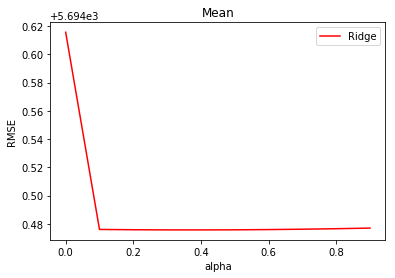

In [119]:
plt.plot(alpharange,ridge,color="red",label="Ridge")
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title("Mean")
plt.legend()

El alpha óptimo para la regresión ridge es de 0.4.

In [120]:
reg = Ridge(alpha=alpha_optimo, random_state=1)
reg.fit(x_train, y_train)

Ridge(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [144]:
predict_ridge_train = reg.predict(X = x_train)
predict_ridge_test  = reg.predict(X = x_test)

In [145]:
rmse_ridge2 = mean_squared_error(
                y_true  = y_test,
                y_pred  = predict_ridge_test
               )
print(f"El error (rmse) de test es: {np.sqrt(rmse_ridge2)}")

El error (rmse) de test es: 5801.019583050098


**Gradient Boosting**

Para el gradient boosting se encontrará el mejor rendimiento realizando diferentes combinaciones de los hiperparámetros: *max_features*, *max_depth*, *subsample* y *learning_rate*. Adicionalmente, se realizará validación cruzada para cada iteración con la función *RandomizedSearchCV*.

In [129]:
model = GradientBoostingRegressor()
param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

randm = RandomizedSearchCV(estimator=model, 
                           param_distributions = param_grid,
                           cv = 10, 
                           n_iter = 5, 
                           n_jobs=-1, 
                           verbose=3, 
                           random_state=1,
                           scoring = 'neg_mean_absolute_error')
randm.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [None, 1, 3, 5, 10, 20], 'subsample': [0.5, 1], 'learning_rate': [0.001, 0.01, 0.1]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=3)


In [141]:
randm.best_params_, randm.best_score_, randm.best_estimator_

({'subsample': 0.5,
  'max_features': 'log2',
  'max_depth': 10,
  'learning_rate': 0.1},
 -3931.393548451928,
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False))

La mejor combinación es: *subsample=0.5*, *max_features=log2*, *max_depth=10* y *learning_rate=0.1*.

In [134]:
gboost = GradientBoostingRegressor(subsample=0.5, max_features="log2", max_depth=10, learning_rate=0.1, random_state=1)
gboost.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=1,
             subsample=0.5, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [146]:
predict_gboost_train = gboost.predict(X = x_train)
predict_gboost_test  = gboost.predict(X = x_test)

In [147]:
rmse_gboost2 = mean_squared_error(
                y_true  = y_test,
                y_pred  = predict_gboost
               )
print(f"El error (rmse) de test es: {np.sqrt(rmse_gboost2)}")

El error (rmse) de test es: 5766.782896337585


**Random Forest**

Para el random forest se encontrará el mejor rendimiento realizando diferentes combinaciones de los hiperparámetros: *n_estimators*, *max_features* y *max_depth*. Adicionalmente, se realizará validación cruzada para cada iteración con la función *RandomizedSearchCV*.

In [149]:
random_grid = {'n_estimators': range(20, 200, 30),
               'max_features': ['auto', 'sqrt'],
               'max_depth': range(10, 110, 20)}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               scoring = 'neg_mean_absolute_error', 
                               n_iter = 5, 
                               cv = 10, 
                               verbose=3, 
                               random_state=1, 
                               n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
({'n_estimators': 80,
  'max_features': 'auto',
  'max_depth': 90)


In [148]:
rf_random.best_params_, rf_random.best_score_, rf_random.best_estimator_

({'n_estimators': 80, 'max_features': 'auto', 'max_depth': 90},
 -3201.7186451335174,
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False))

La mejor combinación es: *n_estimators=80*, *max_features=auto* y *max_depth=90*.

In [150]:
rf = RandomForestRegressor(n_estimators=80, max_features="auto", max_depth=90, random_state=1)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [152]:
predict_rf_train = rf.predict(X = x_train)
predict_rf_test  = rf.predict(X = x_test)

In [153]:
rmse_rf2 = mean_squared_error(
                y_true  = y_test,
                y_pred  = predict_rf_test
               )
print(f"El error (rmse) de test es: {np.sqrt(rmse_rf2)}")

El error (rmse) de test es: 5323.155589991751


**XGBoost**

Para el xtreme gradient boosting se encontrará el mejor rendimiento realizando diferentes combinaciones de los hiperparámetros: *colsample_bytree*, *learning_rate* y *gamma*. Adicionalmente, se realizará validación cruzada para cada iteración con la función *RandomizedSearchCV*.

In [159]:
clf_xgb = XGBRegressor()

param_dist = {'colsample_bytree': [0.01, 0.1, 0.5, 1],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'gamma': [0.01, 0.1, 5, 50],
             }

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 10,  
                         n_iter = 5, 
                         scoring = 'neg_mean_absolute_error', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,
                         random_state=1)

clf.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
RandomizedSearchCV(cv=10, error_score=0,
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'colsample_bytree': [0.01, 0.1, 0.5, 1], 'learning_rate': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 5, 50]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=3)


In [160]:
clf.best_params_, clf.best_score_, clf.best_estimator_

({'learning_rate': 1, 'gamma': 0.1, 'colsample_bytree': 0.5},
 -3383.499805189865,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
        importance_type='gain', learning_rate=1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1))

La mejor combinación es: *learning_rate=1*, *gamma=0.1* y *colsample_bytree=0.5*.

In [161]:
xgboost = XGBRegressor(learning_rate=1, gamma=0.1, colsample_bytree=0.5, random_state=1)
xgboost.fit(x_train, y_train)

[18:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
       importance_type='gain', learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [162]:
predict_xgboost_train = xgboost.predict(x_train)
predict_xgboost_test  = xgboost.predict(x_test)

In [163]:
rmse_xgboost2 = mean_squared_error(
                y_true  = y_test,
                y_pred  = predict_xgboost_test
               )
print(f"El error (rmse) de test es: {np.sqrt(rmse_xgboost2)}")

El error (rmse) de test es: 5211.97378270594


**Stacking**

Finalmente, se realizará un ensamble a través de stacking con los 5 modelos propuestos y calibrados anteriormente. Para esto se usará un modelo de regresión lineal con penalización Ridge. Esta regresión también se calibrará para encontrar el alpha óptimo con la función cross_validate.

In [194]:
df_staking_train = pd.DataFrame({"predict_arbol_train":list(predict_arbol_train),
                                 "predict_ridge_train":list(predict_ridge_train),
                                 "predict_rf_train":list(predict_rf_train),
                                 "predict_gboost_train":list(predict_gboost_train),
                                 "predict_xgboost_train":list(predict_xgboost_train),
                                 "Price":list(y_train)})

df_staking_test  = pd.DataFrame({"predict_arbol_test":list(predict_arbol_test),
                                 "predict_ridge_test":list(predict_ridge_test),
                                 "predict_rf_test":list(predict_rf_test),
                                 "predict_gboost_test":list(predict_gboost_test),
                                 "predict_xgboost_test":list(predict_xgboost_test)})

In [195]:
alpharange = np.arange(0, 1, 0.1)
ridge = []
for alpha in alpharange:
    reg = Ridge(alpha=alpha, random_state=1)
    regs = np.mean(cross_validate(CV=10, model=reg, data=df_staking_train))
    ridge.append(regs)
    print(regs)

1644.0716177290549
1644.0716177290549
1644.0716177290549
1644.0716177290549
1644.0716177290547
1644.0716177290549
1644.0716177290549
1644.0716177290549
1644.0716177290549
1644.0716177290549


In [185]:
results_ridge = pd.DataFrame({'alpha':alpharange,'rmse':ridge})
alpha_optimo = results_ridge.sort_values(by=('rmse')).iloc[0,0]
alpha_optimo

0.4

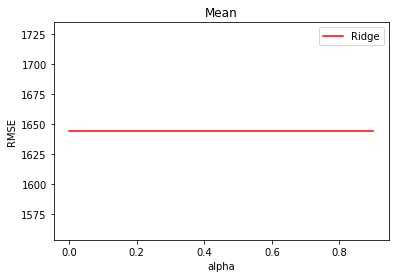

In [186]:
plt.plot(alpharange,ridge,color="red",label="Ridge")
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title("Mean")
plt.legend()

Se obtiene el mismo RMSE con cualquier alpha dentro del rango propuesto para la regresión ridge.

In [188]:
reg = Ridge(alpha=alpha_optimo, random_state=1)
reg.fit(df_staking_train, y_train)

Ridge(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [196]:
predict_stacking = reg.predict(df_staking_test)

In [197]:
rmse_stacking2 = mean_squared_error(
                  y_true  = y_test,
                  y_pred  = predict_stacking
                 )
print(f"El error (rmse) de test es: {np.sqrt(rmse_stacking2)}")

El error (rmse) de test es: 5728.306056592991


### Conclusiones

A continuación, se presenta el resumen de todos los modelos ajustados:

In [211]:
print("Modelo------------------------ Parámetros por defecto -- Calibración")
print("XGBoost:----------------------", round(rmse_xgboost,2), "-----------------", round(np.sqrt(rmse_xgboost2),2))
print("Random Forest:----------------", round(rmse_rf,2), "-----------------", round(np.sqrt(rmse_rf2),2))
print("Grandient Boosting:-----------", round(rmse_gboost,2), "------------------", round(np.sqrt(rmse_gboost2),2))
print("Regresión lineal ridge:-------", round(rmse_ridge,2), "-----------------", round(np.sqrt(rmse_ridge2),2))
print("Árbol de decisión:------------", round(rmse_arbol,2), "-----------------", round(np.sqrt(rmse_arbol2),2))
print("")
print("Stacking con calibración:-----", round(np.sqrt(rmse_stacking2),2))

Modelo------------------------ Parámetros por defecto -- Calibración
XGBoost:---------------------- 6868.93 ----------------- 5211.97
Random Forest:---------------- 5431.05 ----------------- 5323.16
Grandient Boosting:----------- 6864.9 ------------------ 5766.78
Regresión lineal ridge:------- 5694.48 ----------------- 5801.02
Árbol de decisión:------------ 6749.16 ----------------- 6333.99

Stacking con calibración:----- 5728.31


1. Se evidencia que todos los algoritmos al calibrar sus parámetros tienen mejor rendimiento, a excepción del modelo de regresión lineal con penalización ridge.
2. Se observa que al realizar la calibración de los parámetros de cada modelo, el que mejor ajuste presento es el XGBoost. Inicialmente este modelo presento el peor rendimiento con los parámetros por defecto, este procedimiento ayudo a obtener una mejor precisión.
3. Al considerar en la calibración todas las posibles combinaciones de los hiperparámetros nos permitio obtener la combinación óptima para los modelos gradient boosting, random forest y XGboost. 
2. El modelo de ensamblaje stacking no alcanza un mejor desempeño que el XGBoost y el Random Forest.
4. La selección de variables nos permitio optimizar el tiempo de ejecución de cada modelo, especialmente en los modelos con árboles.

### Save model

Finalmente, el mejor modelo para la predicción del precio para carros usados es el **XGBoost**.

In [214]:
pickle.dump(xgboost, open('best_model_price_xgboost.pkl', 'wb'))

# Exercise P2.2 (50%)

Create an API of the model.

Example:
![](https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/notebooks/images/img015.PNG)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


**A continuación se evidencia la foto de la API funcionando en el terminal de una instancia de AWS y algunos ejemplos de la predicción:**

![](https://github.com/SVM2021/maad1/blob/main/Images/API.JPG?raw=true)


**Nissan Sentra 2010, 10.000KM, Texas**

![Screenshot 1](images/Nissan_Sentra.jpg)

**Mazda 3 2018, 32.000KM, Ohio**

![Screenshot 2](images/Mazda_3.jpg)

**BMW X5 Drive 35i 2020, 50.000KM, Florida**

![Screenshot 2](images/BMW_X5xDrive35i.jpg)

**Subaru Impreza 2010, 80.000KM, California**

![Screenshot 4](images/Subaru_Impreza.jpg)

**Toyota Corolla 4dr 2012, 80.000KM, New York**

![Screenshot 5](images/Toyota_Corolla4dr.jpg)

**Chevrolet Corvette 2dr 2008, 65.000KM, Virginia**

![Screenshot 6](images/Chevrolet_Corvette2dr.jpg)